<a href="https://colab.research.google.com/github/88FaHaD/ML/blob/main/transferlerning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer learning
Taking the already creted model and fiting it to our model

In [1]:
import zipfile

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref=zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()


--2024-02-26 09:53:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   177MB/s    in 0.9s    

2024-02-26 09:53:05 (177 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:

# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")



There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

# Preapearing the data

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:

IMAGE_SHAPE = (160, 160)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


# Creating a tensor board call back

In [6]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


# Prepering transfer learning

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
mobinet="https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-160-feature-vector/versions/2"
effinet="https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b1-feature-vector/versions/2"

In [9]:
def create_model(model_url,num_classes=10):
  #downloading the pretrained model and save it as keras layer
  feature_extraction_layer=hub.KerasLayer(model_url,
                                          trainable=False, # freezing already learned patterns by model
                                          name='Feature_extraction_layer',
                                          input_shape=IMAGE_SHAPE +(3,))
  #The model will pass through pretrained model  and the then will move to our model
  model=tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes,activation='softmax',name='oytput_layer')
  ])

  return model

#Creating mobileinet model


In [10]:
mobilenet_model=create_model(mobinet,num_classes=train_data_10_percent.num_classes)

In [11]:
mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (  (None, 1280)              410208    
 KerasLayer)                                                     
                                                                 
 oytput_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 423018 (1.61 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 410208 (1.56 MB)
_________________________________________________________________


# Compiling the Model

In [17]:
mobilenet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        metrics=['accuracy']
)

#Fiting the model

In [24]:
mobile_history=mobilenet_model.fit(train_data_10_percent,
                                   epochs=10,
                                   steps_per_epoch=(len(train_data_10_percent)),
                                   validation_data=test_data,
                                   validation_steps=len(test_data),
                                   callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                          experiment_name='mobilenetv2')]
                                   )

Saving TensorBoard log files to: tensorflow_hub/mobilenetv2/20240226-100357
Epoch 1/10
24/24 [==============================] - 9s 357ms/step - loss: 0.1560 - accuracy: 0.9933 - val_loss: 0.8439 - val_accuracy: 0.7268
Epoch 2/10
24/24 [==============================] - 8s 348ms/step - loss: 0.1377 - accuracy: 0.9973 - val_loss: 0.8442 - val_accuracy: 0.7248
Epoch 3/10
24/24 [==============================] - 7s 315ms/step - loss: 0.1233 - accuracy: 0.9973 - val_loss: 0.8450 - val_accuracy: 0.7248
Epoch 4/10
24/24 [==============================] - 8s 331ms/step - loss: 0.1112 - accuracy: 0.9973 - val_loss: 0.8531 - val_accuracy: 0.7252
Epoch 5/10
24/24 [==============================] - 8s 344ms/step - loss: 0.0999 - accuracy: 0.9987 - val_loss: 0.8534 - val_accuracy: 0.7264
Epoch 6/10
24/24 [==============================] - 12s 518ms/step - loss: 0.0902 - accuracy: 0.9987 - val_loss: 0.8576 - val_accuracy: 0.7268
Epoch 7/10
24/24 [==============================] - 12s 518ms/step - lo

#Ploting the Losscurve

In [25]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


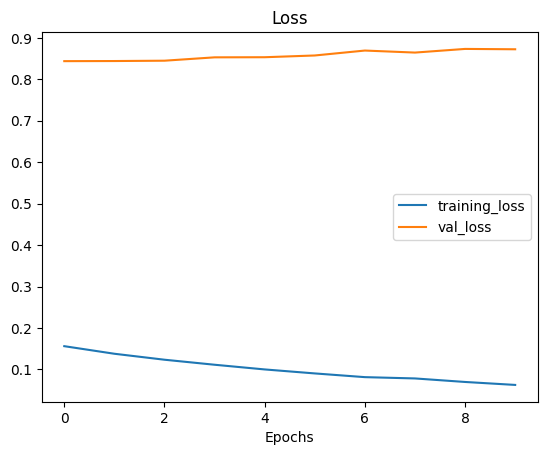

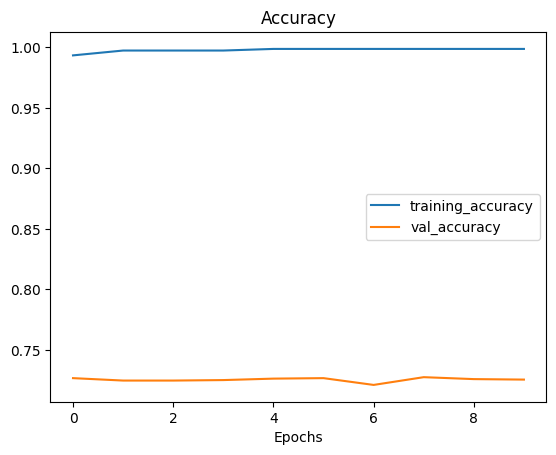

In [26]:
plot_loss_curves(mobile_history)

In [27]:
mobilenet_model.evaluate(test_data)

79/79 [==============================] - 6s 80ms/step - loss: 0.8725 - accuracy: 0.7256


[0.8725404143333435, 0.725600004196167]